### Augmenting program's knowledge: 
Agent knows in advance the total number of mines in the environment grid. 

In [0]:
# Import libraries

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import pprint as pp
from operator import itemgetter
from matplotlib.colors import ListedColormap
import pdb

In [0]:
# Randomly sets n mines in the enviornment grid

def set_mines(grid, n):
  
  count = 0
  d = grid.shape[0]
  
  while count < n:
    (i, j) = (random.randint(0, d - 1), random.randint(0, d - 1))
    if grid[(i,j)] == 0:
      grid[(i,j)] = -1
      count += 1
  return grid

In [0]:
def check_neighbor_validity(neighbor,d):
  
  # If dimensions are in the range
  if neighbor[0] == -1 or neighbor[1] == -1 or neighbor[0] == d or neighbor[1] == d:
    return False    
  else:
    return True

In [0]:
def count_mines(grid, cell):
  
  d = grid.shape[0]
  count = 0
  i = cell[0]
  j = cell[1]
  neighbors = [(i - 1, j - 1), (i - 1, j), (i - 1, j + 1), (i, j - 1), (i, j + 1), (i + 1, j - 1), (i + 1, j), (i + 1, j + 1)]
  
  for neighbor in neighbors:
    if check_neighbor_validity(neighbor,d):
      if grid[neighbor] == -1:
        count += 1
  return count

In [0]:
# Sets the values of the cells in the environemnt grid depending on the mines present in the cell's neighborhood

def set_values(grid, d):
  
  for i in range(d):
    for j in range(d):
      if grid[(i, j)] != -1:
        value = count_mines(grid, (i, j))
        grid[(i, j)] = value
  return grid

In [0]:
def generate_grid(d, n):
  
  grid = np.zeros((d, d))
  grid = set_mines(grid, n)
  grid = set_values(grid, d)
  return grid

#### Function for visualizng the user inference grid: 

In [0]:
def draw_mine(grid):
  
  dim = grid.shape[0]
  
  flatui = ["black", "crimson",  "lightgray", "dimgray"]
  color_palette = sns.color_palette(flatui)
  plt.figure(figsize = (8,8))
  ax = sns.heatmap(grid, annot=True,  linewidths=.01, vmax = 16, vmin = -9, cmap=color_palette, center = 0,  linecolor = 'gray' , cbar = False, xticklabels = False, yticklabels = False) 
  
  for text in ax.texts:
    if text.get_text() == '0' or text.get_text() == '9':
        text.set_size(0)
        text.set_weight('bold')
        text.set_style('italic')
    if text.get_text() == '1':
        text.set_weight('bold')
        text.set_color('blue')
    if text.get_text() == '2':
        text.set_weight('bold')
        text.set_color('green')
    if text.get_text() == '3':
        text.set_weight('bold')
        text.set_color('crimson')
    if text.get_text() == '4':
        text.set_weight('bold')
        text.set_color('darkblue')
    if text.get_text() == '5':
        text.set_weight('bold')
        text.set_color('darkred')
    if text.get_text() == '6':
        text.set_weight('bold')
        text.set_color('olive')
    if text.get_text() == '7':
        text.set_weight('bold')
        text.set_color('midnightblue')
    if text.get_text() == '-1':
        text.set_weight('bold')
        text.set_color('white')
        text.set_text('F')
    if text.get_text() == '-9':
        text.set_weight('bold')
        text.set_color('white')
        text.set_text('M')
  
  plt.show()  

In [0]:
def open_empty_cell(env_grid, user_grid, cell, open_cells,new_cells):
  
  assert env_grid[cell] == 0
  
  d = env_grid.shape[0]
  
  not_bounded = [cell]
  while not_bounded:
    (i, j) = not_bounded.pop()
    neighbors = [(i - 1, j - 1), (i - 1, j), (i - 1, j + 1), (i, j - 1), (i, j + 1), (i + 1, j - 1), (i + 1, j), (i + 1, j + 1)]
  
    for neighbor in neighbors:
      if( check_neighbor_validity(neighbor, d)):
        if(user_grid[neighbor] == 9):
          if( env_grid[neighbor] == 0):
            user_grid[neighbor] = 0
            not_bounded.append(neighbor)
          else:
            user_grid[neighbor] = env_grid[neighbor]
            new_cells.append(neighbor)
          open_cells.append(neighbor)

  
  return user_grid, open_cells, new_cells

In [0]:
def find_neighbor_info(user_grid,cell):
  
  (i,j) = cell
  
  d = user_grid.shape[0]
  
  neighbors = [(i - 1, j - 1), (i - 1, j), (i - 1, j + 1), (i, j - 1), (i, j + 1), (i + 1, j - 1), (i + 1, j), (i + 1, j + 1)]
  hidden_n = []
  
  num_mines = 0
  safe_n = 0
  
  for neighbor in neighbors:
    
    if(check_neighbor_validity(neighbor,d)):
      if(user_grid[neighbor] == 9):
        hidden_n.append(neighbor)
      elif user_grid[neighbor] == -1 or user_grid[neighbor] == -9:
        num_mines = num_mines + 1
      else:
        safe_n = safe_n + 1
        
  return hidden_n,num_mines

In [0]:
def update_knowledge_base(user_grid, new_cells, knowledge_base):
  
    for cell in new_cells:

      if user_grid[cell] > 0 :
      
        hidden_neighbours, num_mines = find_neighbor_info(user_grid,cell)
        cell_value = user_grid[cell] - num_mines
        num_hidden = len(hidden_neighbours)
        
        t = (hidden_neighbours,cell_value,num_hidden)
        if t not in knowledge_base and hidden_neighbours:
          knowledge_base.append(t)
        t_cell = ([cell],0,1)
        if t_cell not in knowledge_base:
          knowledge_base.append(t_cell)
    
      if user_grid[cell] == -1  or user_grid[cell] == -9:
        t = ([cell],1,1)
        if t not in knowledge_base:
          knowledge_base.append(t)
    return knowledge_base

In [0]:
def knowledge_base_approach(env_grid, user_grid, open_cells, new_cells, knowledge_base):
  
  is_update = True
  counter = 0
  
  while True:
    if not is_update and not new_cells and not sure_query_left:
      return user_grid,open_cells,knowledge_base
    
    is_update = False
    counter = counter + 1
#     print(counter)
    
    knowledge_base = update_knowledge_base(user_grid, new_cells, knowledge_base)
    new_cells = []
    
    knowledge_base = sorted(knowledge_base,key=itemgetter(2))
    is_sorted = True
    sure_query_left = False
    
    i = 0
    while True:
      if i >= len(knowledge_base):
        break
      
      set_1 = knowledge_base[i][0]
      set_1_value = knowledge_base[i][1]
      set_1_len = knowledge_base[i][2]
      
      if set_1_len > 1:
        is_sorted = False
      
      if set_1_value == set_1_len:
        is_update = True
        for n in set_1:
          if n:
            assert(env_grid[n] == -1)
            user_grid[n] = -1
            open_cells.append(n)
            t = ([n], 1, 1)
            if t not in knowledge_base:
              knowledge_base.append(t)
            
        if set_1_len > 1:
#           print ("--Popped because mines decomposed: " + str(knowledge_base.pop(i)))
          knowledge_base.pop(i)
          continue
          
        elif set_1_len == 1 and not is_sorted:
          sure_query_left = True
          i += 1
          continue
          
      if set_1_value == 0:
        is_update = True
        if set_1_len > 1:
          for n in set_1:
            if n:
              t = ([n], 0, 1)
              if t not in knowledge_base:
                knowledge_base.append(t)
            
            assert(env_grid[n] != -1)
            if(env_grid[n] == 0):
              user_grid, open_cells, new_cells = open_empty_cell(env_grid, user_grid, n, open_cells, new_cells)
            else:
              new_cells.append(n)
            
            user_grid[n] = env_grid[n]
            open_cells.append(n)
          knowledge_base.pop(i)
#           print("--Popped because safe neighbors decomposed: " + str(knowledge_base.pop(i)))
          continue
          
        elif set_1_len == 1:
          if env_grid[set_1[0]] == 0:
            user_grid, open_cells, new_cells = open_empty_cell(env_grid, user_grid, set_1[0], open_cells, new_cells)
          else:
            new_cells.append(set_1[0])
          user_grid[set_1[0]] = env_grid[set_1[0]]
          open_cells.append(set_1[0])
          if not is_sorted:
            sure_query_left = True
            i += 1
            continue
      
      if new_cells:
#         print("info added for: " + str(new_cells))
        is_update = True
        knowledge_base = update_knowledge_base(user_grid, new_cells, knowledge_base)
        new_cells = []
      
      j = i + 1
      while True:
        if j >= len(knowledge_base):
          break
        
        set_2 = knowledge_base[j][0]
        set_2_value = knowledge_base[j][1]
        
        if set(set_1).issubset(set(set_2)):
          new_set = list(set(set_2)-set(set_1))
          new_value = set_2_value - set_1_value
          new_len = len(new_set)
          new_entry = (new_set, new_value, new_len)
          if new_entry not in knowledge_base and new_set and new_len > 0:
            knowledge_base.append(new_entry)
            is_update = True
            knowledge_base.pop(j)
#             print("--Popped because updated: " + str(knowledge_base.pop(j)))
          else:
            j += 1
          
        else:
          j += 1
      
      if set_1_len == 1:
        if user_grid[set_1[0]] == 9 :
          user_grid[set_1[0]] == env_grid[set_1[0]]
        assert(user_grid[set_1[0]] < 9)
#         print("--Popped because substituted: " + str(knowledge_base.pop(i)))
        knowledge_base.pop(i)
      else:
        i += 1
      
#     print(knowledge_base)

In [0]:
def optimized_approach(env_grid,num_mines):
  
  d = env_grid.shape[0]
  
  user_grid = np.full((d, d),9)  
  
  open_cells = []
  not_visited_list = []
  new_cells = []
  
  for i in range(d):
    for j in range(d):
      not_visited_list.append((i,j))
  
  knowledge_base = [(not_visited_list, num_mines, d*d)]
  
  mine_blasts = 0
  
  v = len(not_visited_list)
  v_cell = random.randint(0,v-1)
  selected_cell = not_visited_list[v_cell]
  
#   print("Random cell: ", selected_cell)

  while(not_visited_list):
    
    if env_grid[selected_cell] == -1:
      mine_blasts += 1
       
    if(env_grid[selected_cell] == 0):
      user_grid[selected_cell] = 0
      user_grid, open_cells,new_cells = open_empty_cell(env_grid, user_grid, selected_cell, open_cells, new_cells)
    elif (env_grid[selected_cell] == -1):
      user_grid[selected_cell] = -9
    else:
      user_grid[selected_cell] = env_grid[selected_cell] 
      new_cells.append(selected_cell)    
    open_cells.append(selected_cell) 

#     print("New Grid")
#     draw_mine(user_grid)

    user_grid, open_cells, knowledge_base = knowledge_base_approach(env_grid, user_grid, open_cells, new_cells, knowledge_base)
    
#     print("Updated Grid")
#     draw_mine(user_grid)

    not_visited_list = list(set(not_visited_list) - set(open_cells))
  
    # To calculate the average probability of each undiscovered cell
 
    probability = []
    
    for cell in not_visited_list:
      
      total_probability = 0
      count = 0
      cell_list = [cell]
      
      for i in range(len(knowledge_base)):
        if( set(cell_list).issubset( set(knowledge_base[i][0]) ) ):
          total_probability  += knowledge_base[i][1] / knowledge_base[i][2]
          count += 1
          
      probability.append( (cell, total_probability/count) )
    
    if(len(not_visited_list)!=0):

      selected_cell = min(probability, key = lambda t: t[1])   # selecting the cell with minimum probability of having a mine
      selected_cell = selected_cell[0]

  score = num_mines - mine_blasts
  
  return score

#### A demonstration of inference at each level: 

The user grid is visualized after a random restart and the updated user grid inferred from the algorithm. For visualization purposes, we have run this algorithm on a lower dimension. 
The mines marks as flags are the inferenced mines. The mines marked as 'M' are mines which are encountered during random restart. 

Note: To visualize the grid, uncomment the lines in 'optimized_approach' method.
 

Random cell:  (8, 14)
New Grid


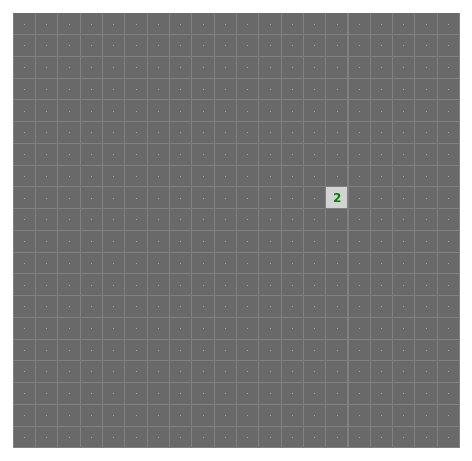

Updated Grid


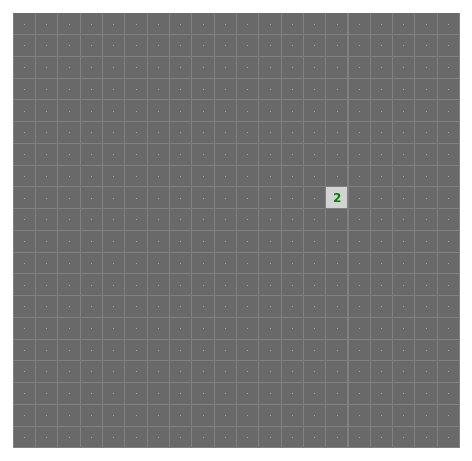

New Grid


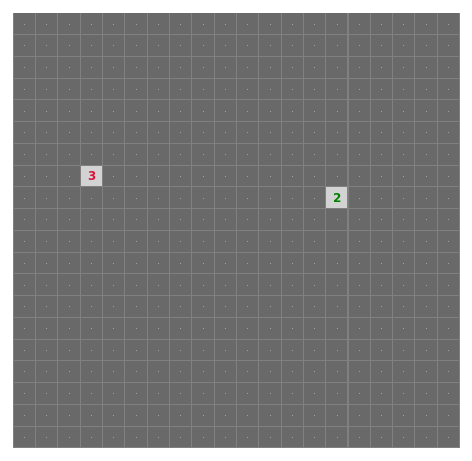

Updated Grid


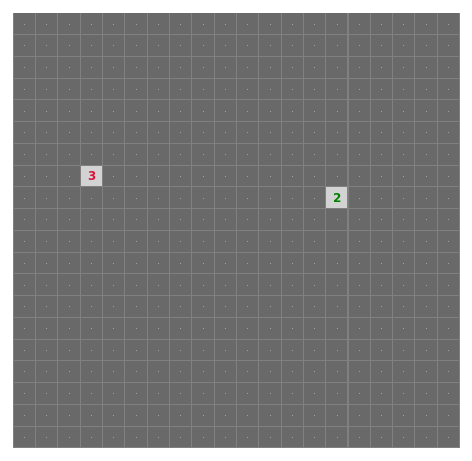

New Grid


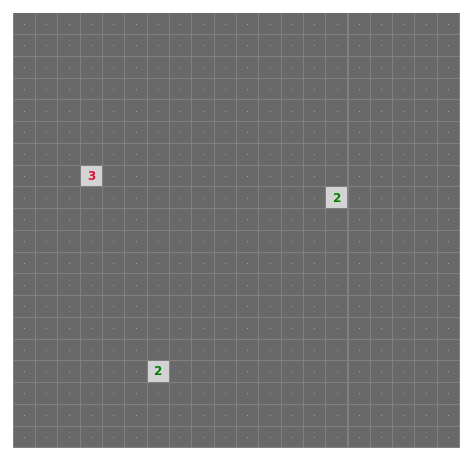

Updated Grid


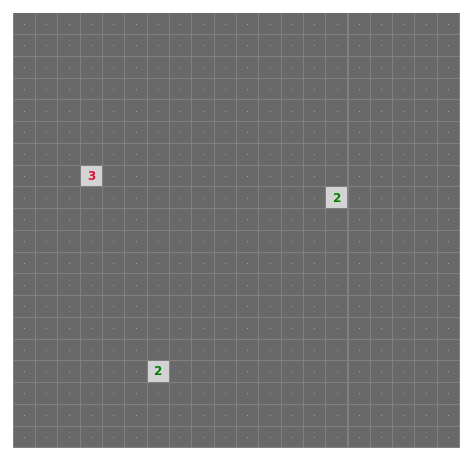

New Grid


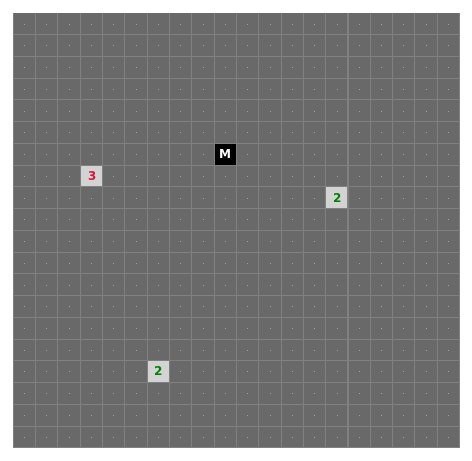

Updated Grid


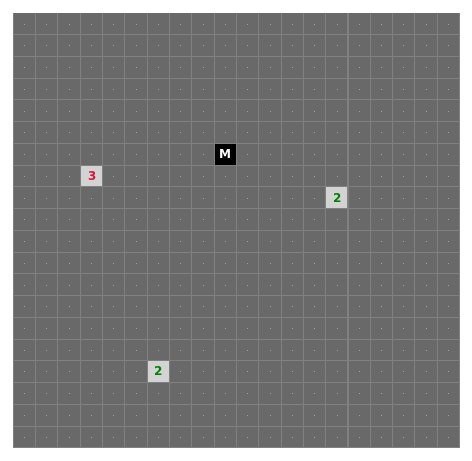

New Grid


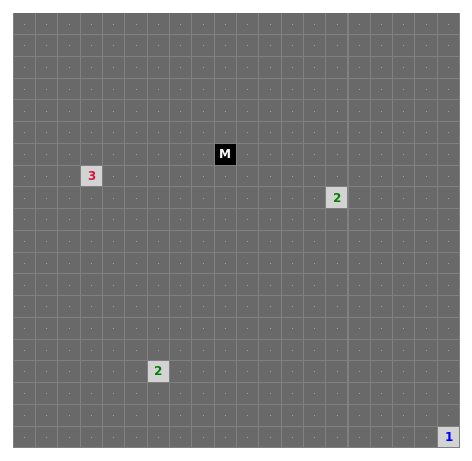

Updated Grid


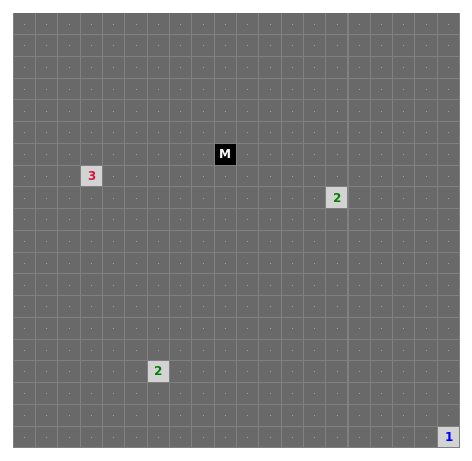

New Grid


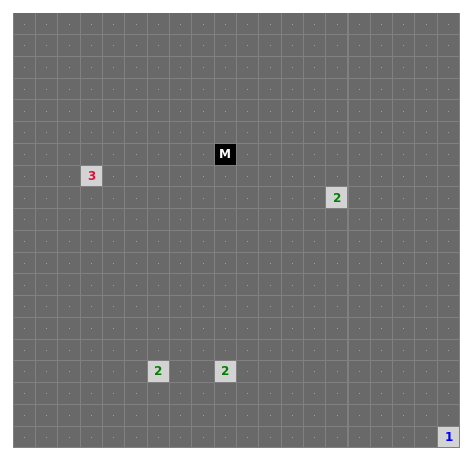

Updated Grid


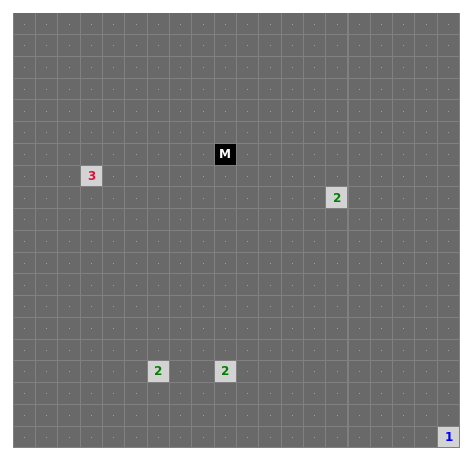

New Grid


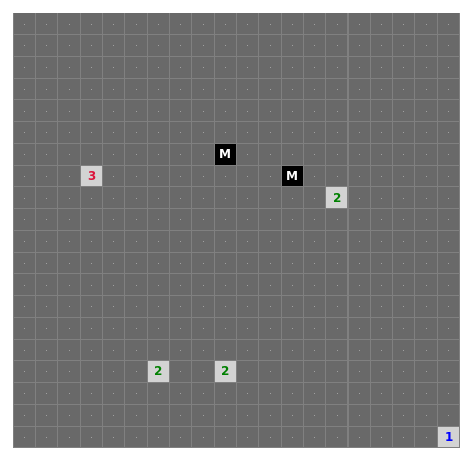

Updated Grid


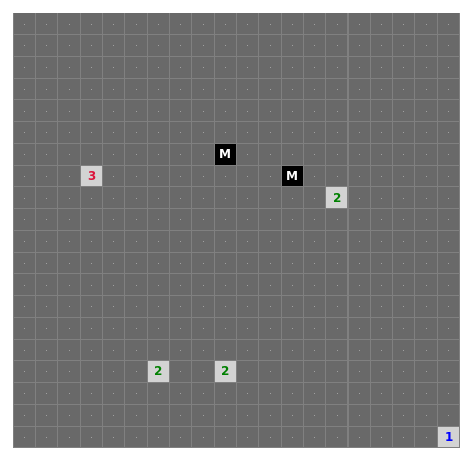

New Grid


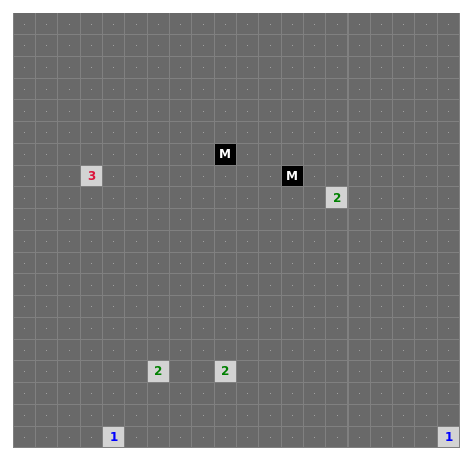

Updated Grid


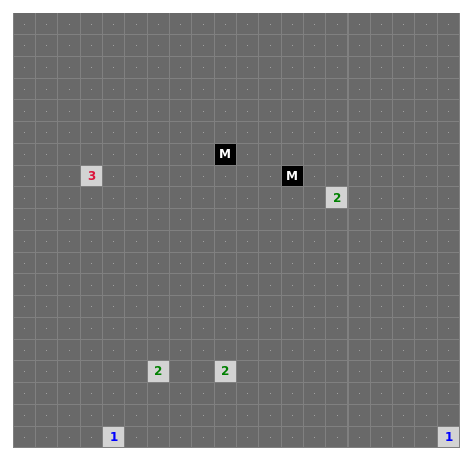

New Grid


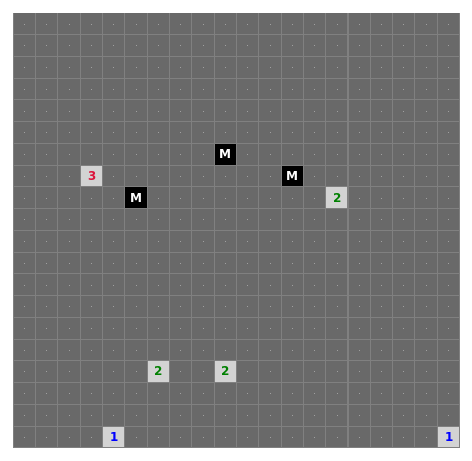

Updated Grid


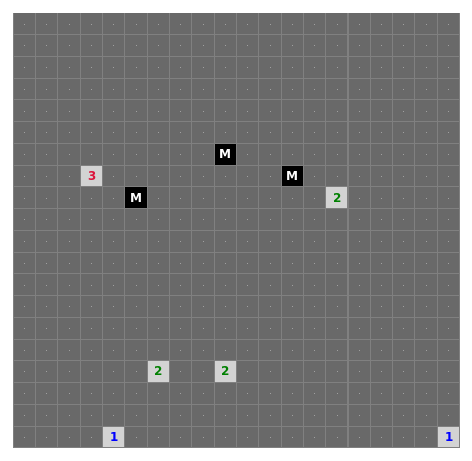

New Grid


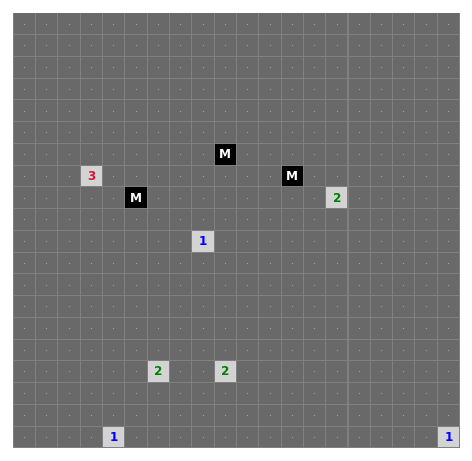

Updated Grid


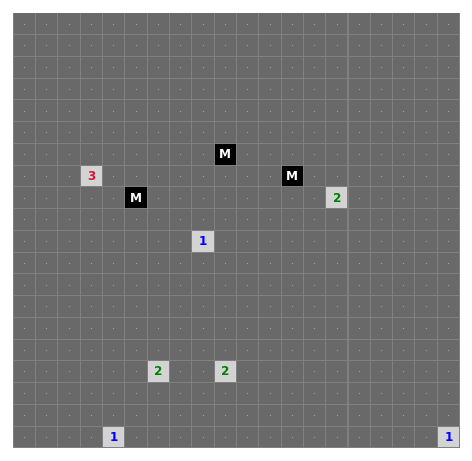

New Grid


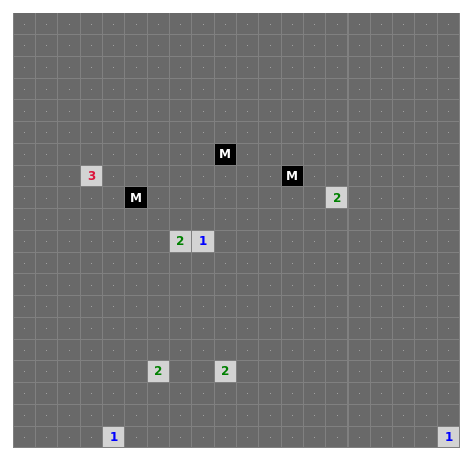

Updated Grid


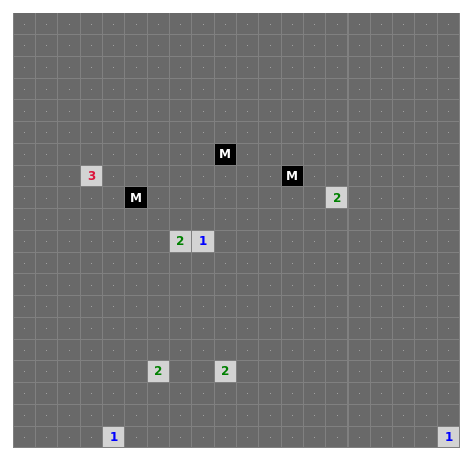

New Grid


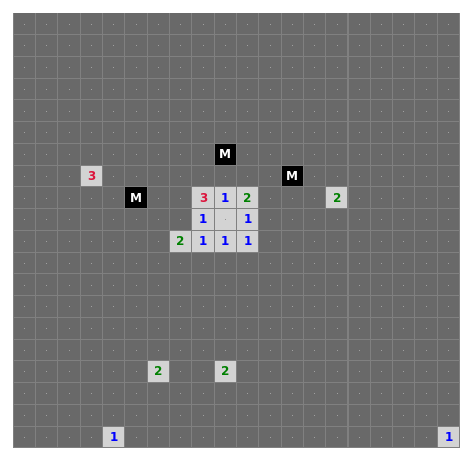

Updated Grid


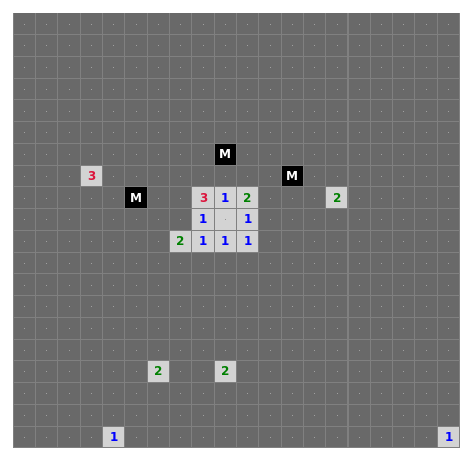

New Grid


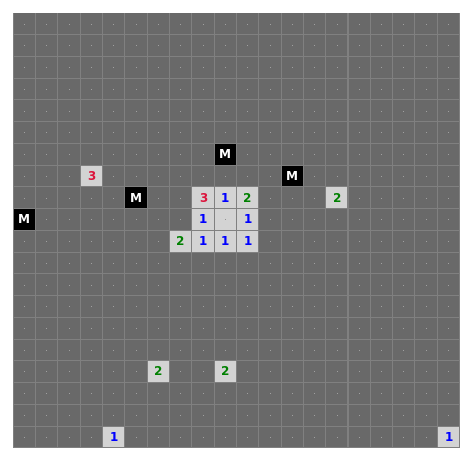

Updated Grid


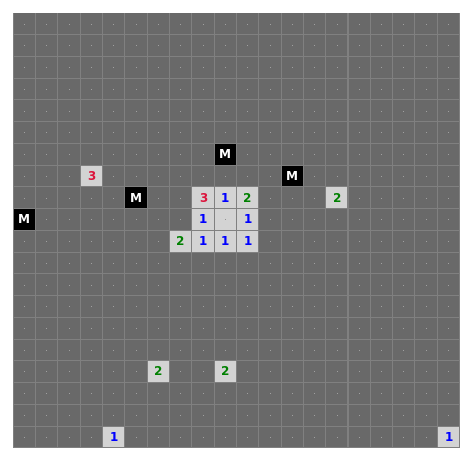

New Grid


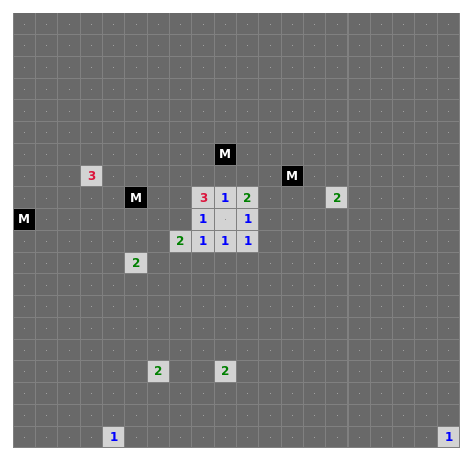

Updated Grid


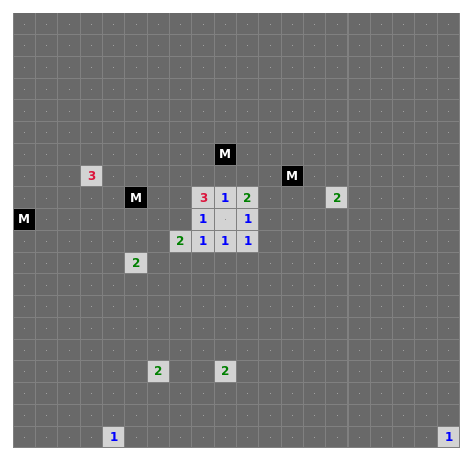

New Grid


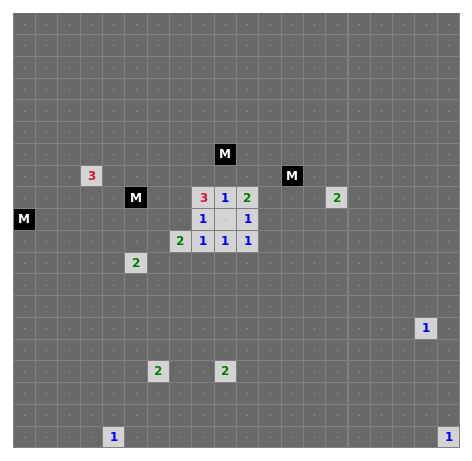

Updated Grid


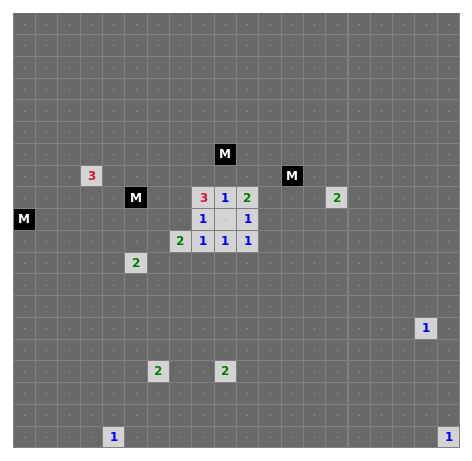

New Grid


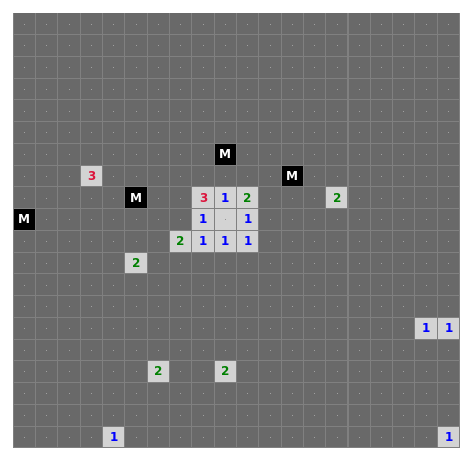

Updated Grid


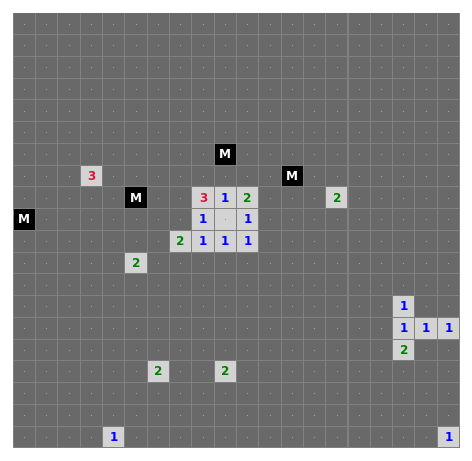

New Grid


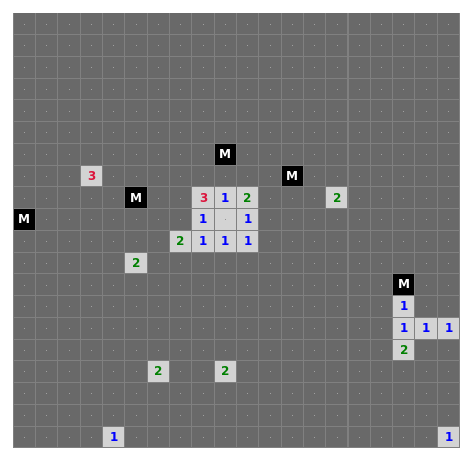

Updated Grid


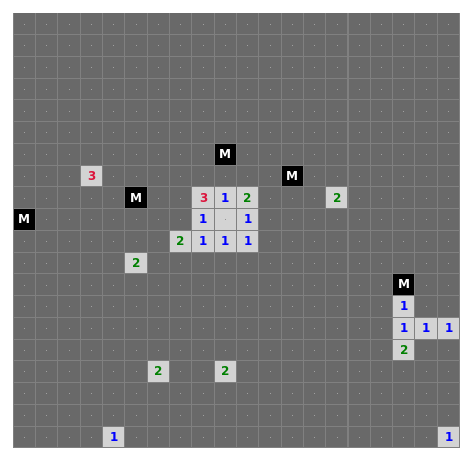

New Grid


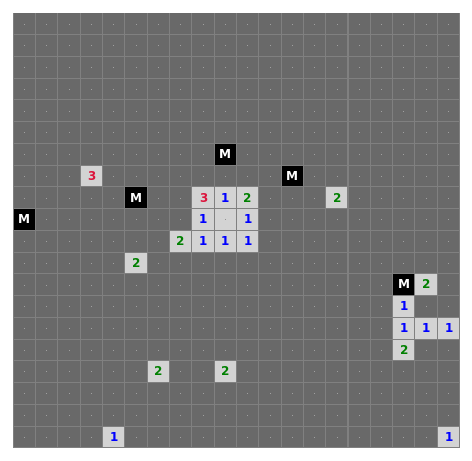

Updated Grid


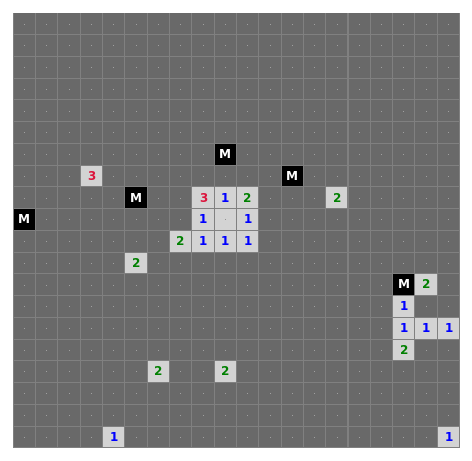

New Grid


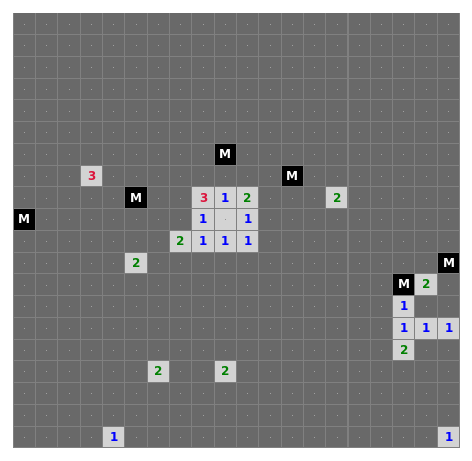

Updated Grid


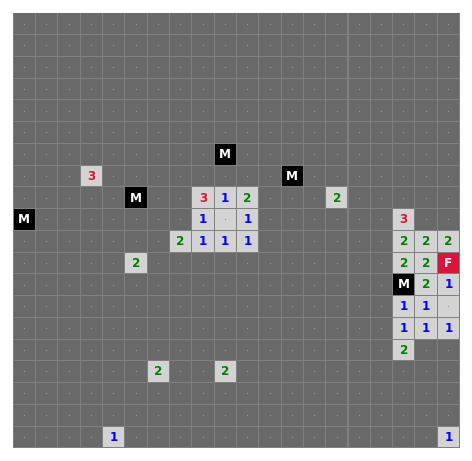

New Grid


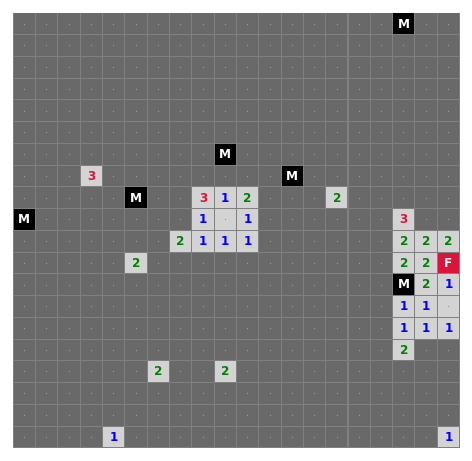

Updated Grid


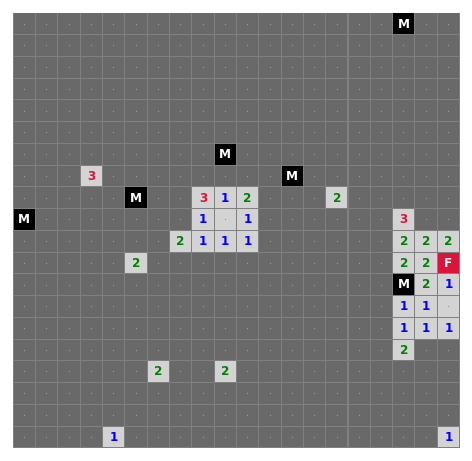

New Grid


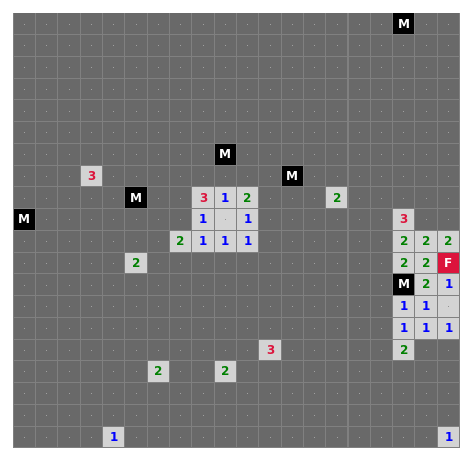

Updated Grid


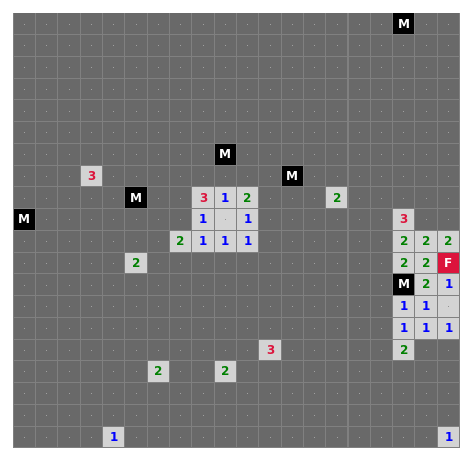

New Grid


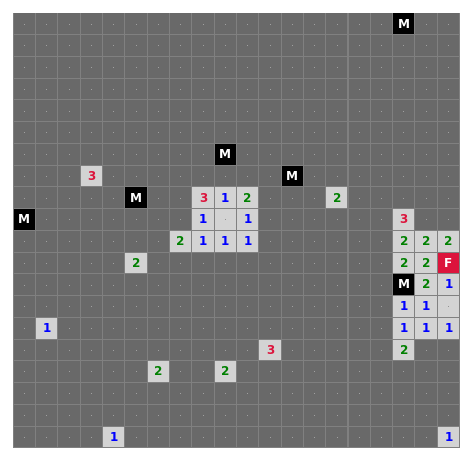

Updated Grid


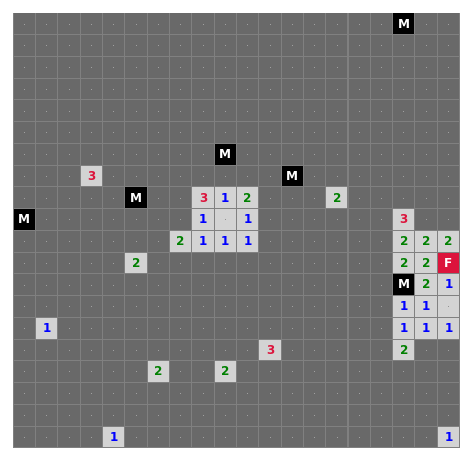

New Grid


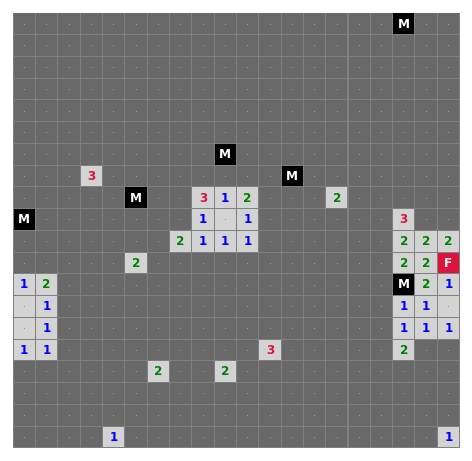

Updated Grid


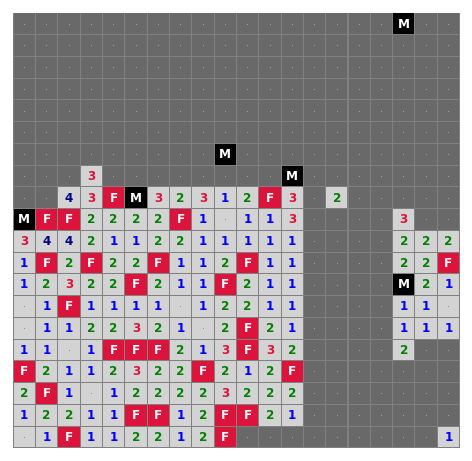

New Grid


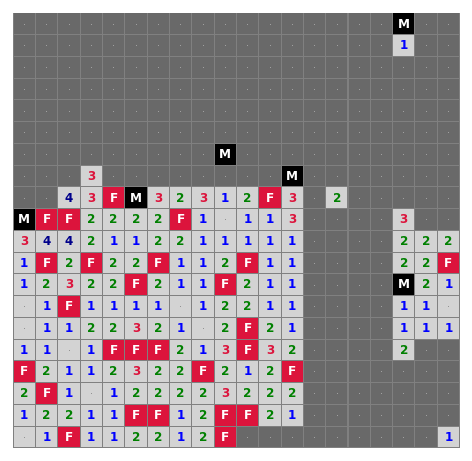

Updated Grid


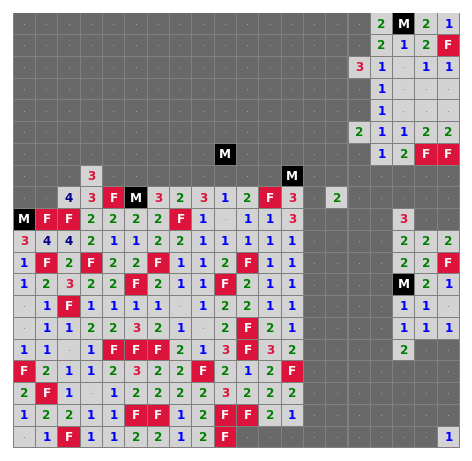

New Grid


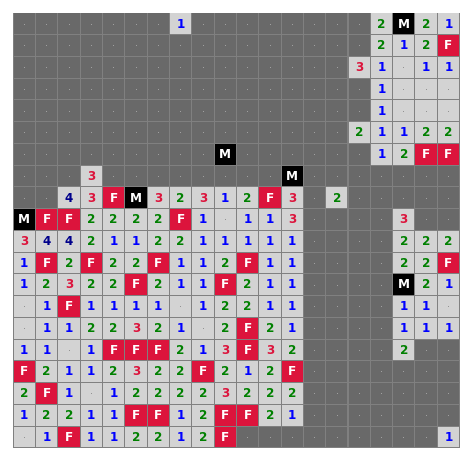

Updated Grid


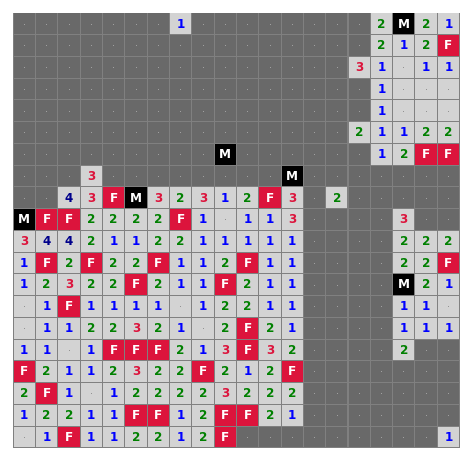

New Grid


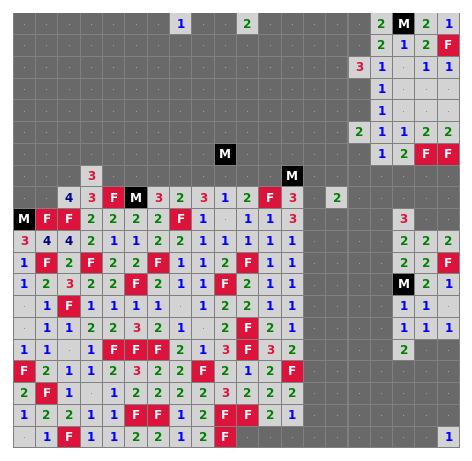

Updated Grid


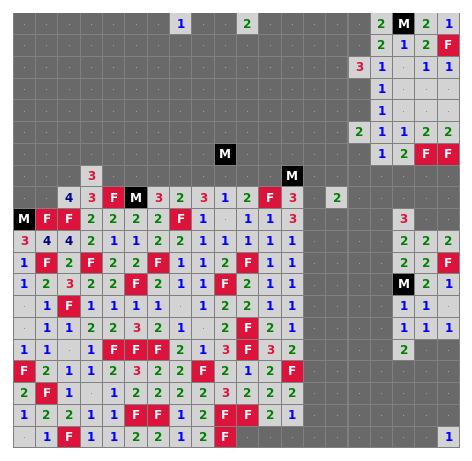

New Grid


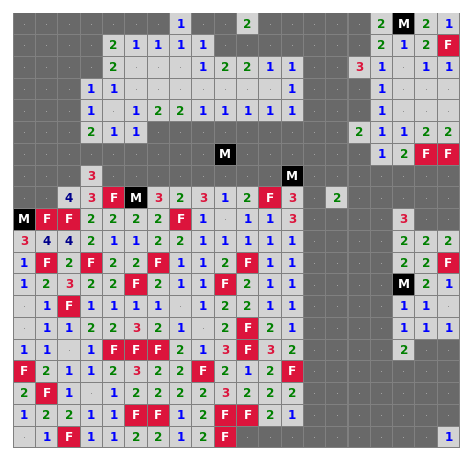

Updated Grid


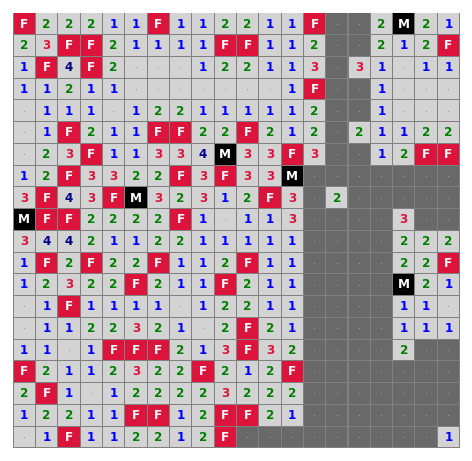

New Grid


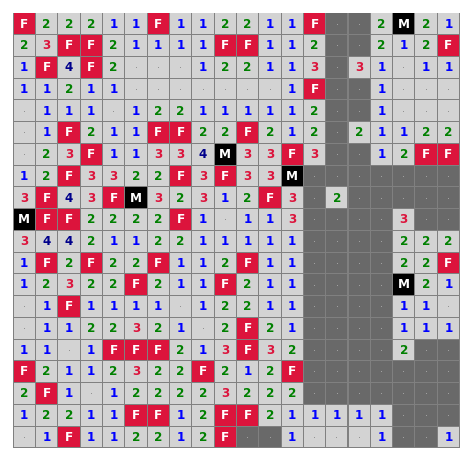

Updated Grid


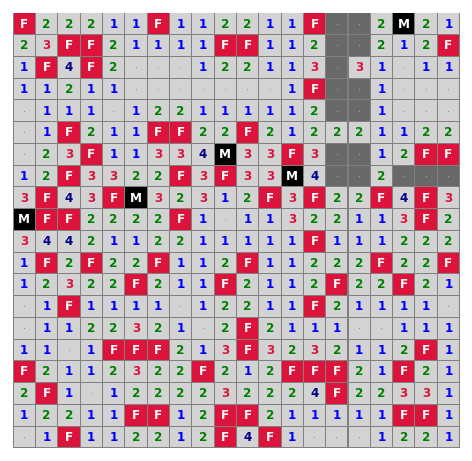

New Grid


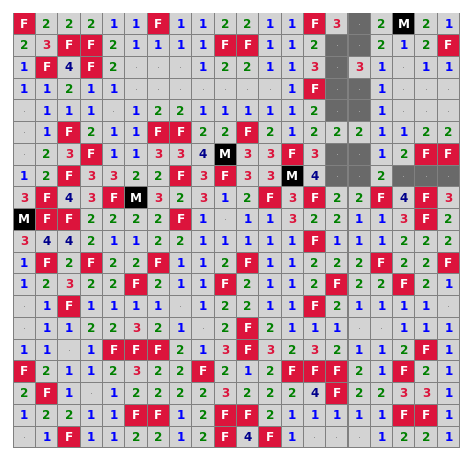

Updated Grid


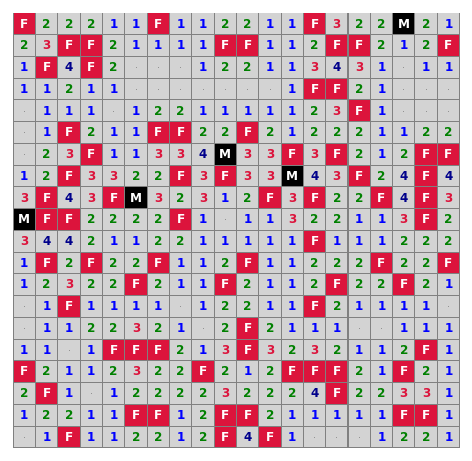

Score : 73
Time taken to solve a (20 * 20) grid with 80 mines = 65.92682790756226


In [0]:
start_time = time.time()
dim = 20
num_mines = 80

test_grid = generate_grid(dim, num_mines)
score = optimized_approach(test_grid,num_mines)
print("Score : " + str(score))
print("Time taken to solve a (" + str(dim) + " * " + str(dim) + ") grid with " + str(num_mines) + " mines = " + str(time.time()-start_time))

##### To find the average score and average time taken to solve a mine grid of 30x30 dimension and with 300 mines: 

In [0]:
def solve_game(dim,num_mines):
  start_time = time.time()
  print("Without total mine count - Optimized approach")
  print("(" + str(dim) + " * " + str(dim) + ") grid with " + str(num_mines) + " mines:\n")

  avg_score = 0
  avg_time = 0

  for i in range(10):
    start_time = time.time()
    test_grid = generate_grid(dim, num_mines)
    score = optimized_approach(test_grid,num_mines)
    time_taken = time.time()-start_time
    avg_score += score
    avg_time += time_taken
    print(str(i) + ")\tScore: " + str(score) + "/" + str(num_mines) + "\tTime: " + str(time_taken))

  print("\nAverage - \tScore: " + str(avg_score/10) + "/" + str(num_mines) + "\tTime: " + str(avg_time/10))

In [0]:
solve_game(30,300)

Without total mine count - Optimized approach
(30 * 30) grid with 300 mines:

0)	Score: 271/300	Time: 6.044452905654907
1)	Score: 272/300	Time: 5.078073263168335
2)	Score: 258/300	Time: 11.789765119552612
3)	Score: 271/300	Time: 5.151532173156738
4)	Score: 268/300	Time: 6.205431938171387
5)	Score: 262/300	Time: 6.891619443893433
6)	Score: 276/300	Time: 3.049008369445801
7)	Score: 271/300	Time: 7.482496023178101
8)	Score: 263/300	Time: 8.907790422439575
9)	Score: 276/300	Time: 7.377292156219482

Average - 	Score: 268.8/300	Time: 6.797746181488037


#### To find the average score for different mine densities: 

In [0]:
def average_score(dim):
  
  num_cells = dim*dim
  mine_density = [int(num_cells*0.1), int(num_cells*0.2), int(num_cells*0.3), int(num_cells*0.4), int(num_cells*0.5)]
  avg_score = []
  
  for num_mines in mine_density:
    
    start_time = time.time()
    sum_score = 0
    num_iteration = 10
    
    for i in range(num_iteration):
      
      env_grid = generate_grid(dim, num_mines)
      score = optimized_approach(env_grid,num_mines)   
      sum_score = sum_score + score
      
    avg_score_temp = sum_score/num_iteration
    avg_score_temp = (avg_score_temp/num_mines)*100    
    avg_score.append(avg_score_temp)
    
  print("Average_score", avg_score)
  print("mine_density", mine_density)
  
  ### Average score ###
  sns.set(style="whitegrid", color_codes=True)
  pal = sns.color_palette("Greens_d", len(mine_density))

  sns.lineplot(mine_density, avg_score, palette=np.array(pal[::-1]),  marker='o',  dashes=False, color = "teal")
  plt.xlabel("Mine density")
  plt.ylabel("Average score (%) ")
  plt.title(" Mine density vs Average score for dimension = "+ str(dim))

  plt.show()

Average_score [99.6875, 98.75, 92.0, 85.015625, 77.975]
mine_density [160, 320, 480, 640, 800]


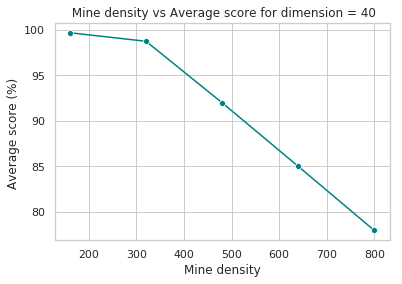

In [0]:
# For a grid 40*40
average_score(40)